In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

# Load Data
awplr_inflation_data = pd.read_csv("../data/awplr_inflation_data_till_2020.csv")
awplr_inflation_data["Date"] = pd.to_datetime(awplr_inflation_data["Date"])
awplr_inflation_data.set_index("Date", inplace=True)
awplr_inflation_data.ffill(inplace=True)

# Feature Engineering: Moving Averages & Lag Features
awplr_inflation_data["AWPLR_MA_3"] = awplr_inflation_data["AWPLR"].rolling(window=3).mean()
awplr_inflation_data["AWPLR_MA_6"] = awplr_inflation_data["AWPLR"].rolling(window=6).mean()
awplr_inflation_data["AWPLR_LAG_1"] = awplr_inflation_data["AWPLR"].shift(1)
awplr_inflation_data["AWPLR_DIFF"] = awplr_inflation_data["AWPLR"].diff()
awplr_inflation_data.bfill(inplace=True)

# Feature Selection
features = ["AWPLR", "NCPI_Headline", "NCPI_Core", "CCPI_Headline", "AWPLR_MA_3", "AWPLR_MA_6", "AWPLR_LAG_1", "AWPLR_DIFF"]

# Normalize Data
scaler = StandardScaler()
awplr_scaled = scaler.fit_transform(awplr_inflation_data[features])
awplr_scaled = pd.DataFrame(awplr_scaled, index=awplr_inflation_data.index, columns=features)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length].values)
        y.append(data.iloc[i + seq_length, 0])  # Predicting next AWPLR
    return np.array(X), np.array(y)

sequence_length = 6
X, y = create_sequences(awplr_scaled, sequence_length)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build Enhanced LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True, activation="tanh", input_shape=(sequence_length, X.shape[2]), kernel_regularizer=l2(0.001))))
model.add(Dropout(0.05))
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.05))
model.add(Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001))))
model.add(Dense(1))

# Compile Model
model.compile(optimizer="adam", loss="mse")

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train Model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop, reduce_lr])

model.save("../model/lstm_awplr_model.h5")

print("Model Saved to model/lstm_awplr_model.h5")

Epoch 1/200


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - loss: 2.6774 - val_loss: 1.5621 - learning_rate: 0.0010
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.9252 - val_loss: 1.4530 - learning_rate: 0.0010
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5891 - val_loss: 1.3942 - learning_rate: 0.0010
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.4269 - val_loss: 1.3353 - learning_rate: 0.0010
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4002 - val_loss: 1.2884 - learning_rate: 0.0010
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3076 - val_loss: 1.2263 - learning_rate: 0.0010
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.2381 - val_loss: 1.1553 - learning_rate: 0.0010
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1953 - val_loss: 1.1015 - learning_rate: 0.0010
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.1342 - val_loss: 1.0530 - learning_rate: 0.0010
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

Model Saved to model/lstm_awplr_model.h5


In [11]:
# Rolling Forecast
future_steps = 6  # Predict next 6 months
future_predictions = []
current_input = np.mean(X_test[-5:], axis=0)

for _ in range(future_steps):
    next_prediction = model.predict(current_input.reshape(1, sequence_length, X.shape[2]))
    future_predictions.append(next_prediction[0, 0])
    current_input = np.roll(current_input, -1, axis=0)
    current_input[-1] = 0.8 * current_input[-2] + 0.2 * next_prediction

# Inverse Transform Predictions
def inverse_transform(scaler, data, predictions, num_features):
    predictions = np.array(predictions).reshape(-1, 1)
    padded_predictions = np.concatenate((predictions, np.zeros((predictions.shape[0], num_features - 1))), axis=1)
    return scaler.inverse_transform(padded_predictions)[:, 0]

y_test_original = inverse_transform(scaler, awplr_scaled, y_test, len(features))
predictions = model.predict(X_test)
predictions_original = inverse_transform(scaler, awplr_scaled, predictions, len(features))
#future_predictions_original = inverse_transform(scaler, awplr_scaled, future_predictions, len(features))
future_predictions_original = inverse_transform(scaler, awplr_scaled, future_predictions[:6], len(features))




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [29]:
# Calculate Metrics
mae = mean_absolute_error(y_test_original, predictions_original)
mse = mean_squared_error(y_test_original, predictions_original)
rmse = mse ** 0.5
r2 = r2_score(y_test_original, predictions_original)

# Print Results
#print(predictions_original)
print(future_predictions_original)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

[5.96735927 5.88796201 6.11884721 6.24922253 6.56856621 7.18453615
 8.03503259 9.22711967 9.50879852 9.30778167 9.15807713 9.41723872]
[9.28808923 9.30270758 9.18512686 8.99376334 8.75568518 8.48708446]
Mean Absolute Error (MAE): 0.2591
Root Mean Squared Error (RMSE): 0.3435
R² Score: 0.9484


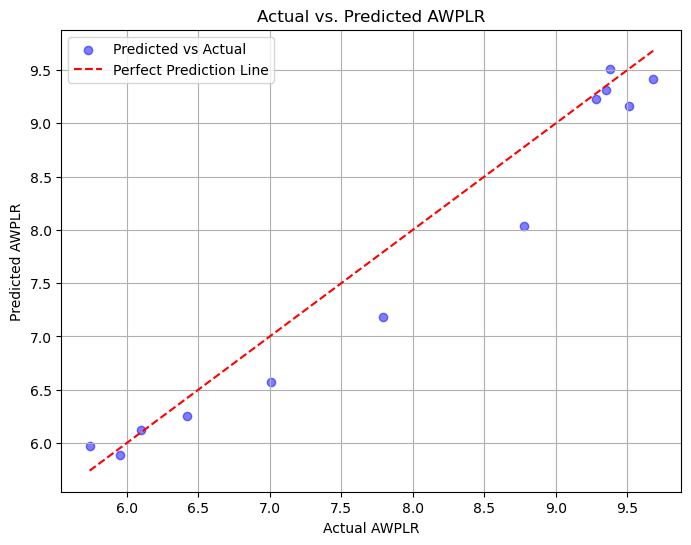

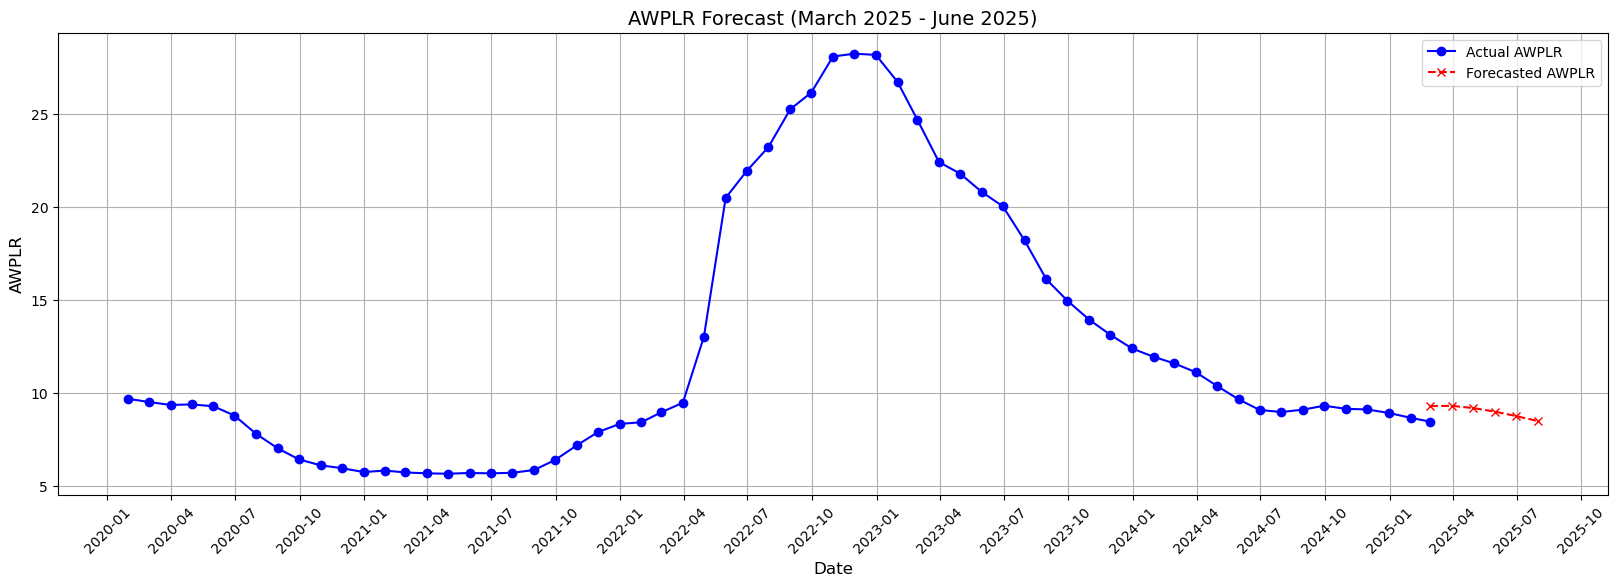

In [31]:
# Scatter Plot - Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, predictions_original, color='blue', label="Predicted vs Actual", alpha=0.5)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--', label="Perfect Prediction Line")
plt.xlabel("Actual AWPLR")
plt.ylabel("Predicted AWPLR")
plt.title("Actual vs. Predicted AWPLR")
plt.legend()
plt.grid(True)
plt.show()

# Time-Series Forecast Plot
actual_dates = awplr_inflation_data.index[-len(y_test_original):]
future_dates = pd.date_range(start="2025-02-28", periods=len(future_predictions_original), freq="ME")

plt.figure(figsize=(20, 6))
plt.plot(awplr_inflation_data.index, awplr_inflation_data["AWPLR"], label="Actual AWPLR", color="blue", marker="o")
plt.plot(future_dates, future_predictions_original, label="Forecasted AWPLR", color="red", linestyle="--", marker="x")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.title("AWPLR Forecast (March 2025 - June 2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("AWPLR", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()